# Aprendiendo Redes Neuronales

En este notebook, realizamos una primera aproximación a las redes neuronales. Vamos a usarlas para resolver un problema sencillo de clasificación donde deberemos clasificar dos anillos concéntricos.

Vamos a implementar las redes neuronales desde el nivel más bajo de abstracción al nivel más alto:

+ Python: implementamos desde cero las redes neuronales, "picando" el código necesario para crear la estructura de datos que almacena la red neuronal y las funciones para entrenarla.

+ Tensorflow: subimos un escalón en el nivel de abstracción. Con la librería Tensorflow, no tendremos que crearnos la estructura de datos de la red neuronal. Más bien, tenemos describir cada una de las capas con gran capacidad de detalle. Donde más ventaja tenemos es a la hora de entrenarla, pues lo hace automáticamente y de forma optimizada. 

+ Keras: nivel intermedio de abstracción. Donde notamos la diferencia con Tensorflow es que es más sencillo configurar las capas. A cambio, perdemos un poco de capacidad de detalle.

+ Sklearn: llegamos al último nivel. Simplemente tenemos varios modelos de redes neuronales de entre los que podemos elegir. La dificultad reside en conseguir la combinación de parámetros más conveniente. No tenemos apenas capacidad de detalle a la hora de configurar la red neuronal.

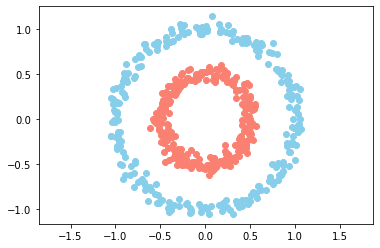

In [15]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

#Creamos el dataset. El problema tratara de clasificar dos anillos concentricos
X, Y = make_circles(n_samples = 500, factor = 0.5, noise = 0.05)
Y = Y[:, np.newaxis]

#Visualizamos el dataset para aclarar cual es nuestro objetivo
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c = "skyblue")
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c = "salmon")
plt.axis("equal")
plt.show()

In [16]:
from matplotlib import animation
from IPython.core.display import display, HTML #Ojo: para crear la animacion debemos tener instalado ffmpeg

res = 50 #Resolución del mapa de prediccion
_x0 = np.linspace(-1.5, 1.5, res) #Coordenadas del mapa de prediccion
_x1 = np.linspace(-1.5, 1.5, res)
_pX = np.array(np.meshgrid(_x0, _x1)).T.reshape(-1, 2) #Input con cada combo de coordenadas del mapa de prediccion.
_pY = np.zeros((res, res)) + 0.5 #Objeto vacio a 0.5 del mapa de prediccion
    
#Funcion para generar la animacion del entrenamiento (su ejecucion puede tardar varios segundos)
def generateTrainingAnimation(X, Y, iPY):
    print('--- Generando animacion ---')
    
    #No explicamos el siguiente codigo porque no es de interes
    ims = []
    fig = plt.figure(figsize=(10, 10))

    for frame in range(len(iPY)):
        im = plt.pcolormesh(_x0, _x1, iPY[frame], cmap="coolwarm", animated=True)

        # Visualización de la nube de datos
        auxY = Y.ravel()
        plt.scatter(X[auxY == 0,0], X[auxY == 0,1], c="skyblue")
        plt.scatter(X[auxY == 1,0], X[auxY == 1,1], c="salmon")
        plt.tick_params(labelbottom=False, labelleft=False)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    return HTML(ani.to_html5_video())

## Python

In [17]:
#Clase que representa una capa de la red neuronal. Para cada capa tenemos: una funcion de activación, un vector de bias 
#con tantas componentes como neuronas tenga la capa y una matriz de pesos de dimensiones conexiones x neuronas.
class neuralLayer():
        def __init__(self, connectionsNumber, neuronsNumber, activationFunction):
            self.activationFunction = activationFunction
            self.b = np.random.rand(1, neuronsNumber) * 2 - 1
            self.W = np.random.rand(connectionsNumber, neuronsNumber) * 2 - 1

In [18]:
#Funciones de activacion
#Describimos a cada funcion de activacion como una tupla, en donde su primera componente es la propia funcion y la
#segunda componente es su derivada.

sigmoide = (lambda x : 1 / (1 + np.e ** (-x)), 
            lambda x : x * (1 - x))

relu = lambda x : np.maximum(0, x)

meanSquareError = (lambda YPredicted, YReal : np.mean((YPredicted - YReal)**2),  
                   lambda YPredicted, YReal : (YPredicted - YReal))

#Funcion encargada de crear una red neuronal, dada su topologia y su funcion de activacion.
#Describimos la red neuronal como un vector de capas, donde cada capa es la clase creada anteriormente.
def createNeuralNetwork(topology, activationFunction) :
    neuralNetwork = []
    for i, layer in enumerate(topology[:-1]):
        neuralNetwork.append(neuralLayer(topology[i], topology[i+1], activationFunction))
    return neuralNetwork

#Funcion encargada de entrenar a la red neuronal.
#Tambien podemos usarla para solamente predecir poniendo el parametro train a False
def trainNeuralNetwork(neuralNetwork, X, Y, costFunction, learningRate = 0.5, train = True) :
    output = [(None, X)]
    
    #Forward pass (predecimos el resultado para cada dato de entrenamiento)
    for i, layer in enumerate(neuralNetwork):
        z = output[-1][1] @ neuralNetwork[i].W + neuralNetwork[i].b
        a = neuralNetwork[i].activationFunction[0](z)
        output.append((z, a))
    
    if train:
        #Backward pass (calculamos en orden inverso las derivadas parciales de cada capa)
        deltas = []
        
        for i in reversed(range(0, len(neuralNetwork))):
            z = output[i+1][0]
            a = output[i+1][1]
            
            if i == len(neuralNetwork) - 1:
                #Calcular delta ultima capa
                deltas.insert(0, costFunction[1](a, Y) * neuralNetwork[i].activationFunction[1](a))
            else:
                #Calcular delta respecto a capa previa
                deltas.insert(0, deltas[0] @ _W.T * neuralNetwork[i].activationFunction[1](a))
            
            _W = neuralNetwork[i].W
            
            #Gradient descent (aplicamos el algoritmo de descenso de gradiente en cada capa)
            neuralNetwork[i].b = neuralNetwork[i].b - np.mean(deltas[0], axis=0, keepdims=True) * learningRate
            neuralNetwork[i].W = neuralNetwork[i].W - output[i][1].T @ deltas[0] * learningRate
    
    return output[-1][1]

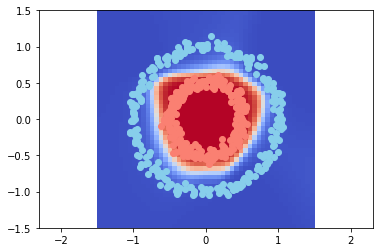

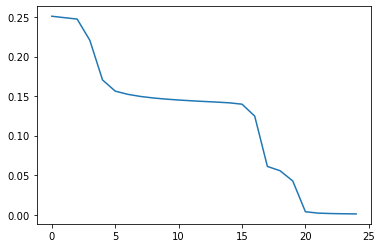

In [20]:
import time
from IPython.display import clear_output

topology = [2, 4, 8, 1] #Topologia de la red neuronal: describimos el número de neuronas por capa
learningRate = 0.025 #Learning rate del optimizador (normalmente descenso del gradiente)
neuralNetwork = createNeuralNetwork(topology, sigmoide) #Creamos la red neuronal
loss = []
nSteps = 2500

for i in range(nSteps):
    
    #Entrenamos la red
    pY = trainNeuralNetwork(neuralNetwork, X, Y, meanSquareError, learningRate = 0.05)
    
    if i % 100 == 0:
        loss.append(meanSquareError[0](pY, Y))
        res = 50
        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)
        
        _Y = np.zeros((res, res))
        
        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                _Y[i0, i1] = trainNeuralNetwork(neuralNetwork, np.array([[x0, x1]]), Y, meanSquareError, train=False)[0][0]
                
        plt.pcolormesh(_x0, _x1, _Y, cmap = "coolwarm")
        plt.axis("equal")
        
        plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c = "skyblue")
        plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c = "salmon")
        
        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(loss)), loss)
        plt.show()
        time.sleep(0.25)

## Tensorflow

In [28]:
import tensorflow as tf

topology = [2, 16, 8, 1]
learningRate = 0.025

#Definimos los placeholders: puntos de entrada de datos de nuestra red
iX = tf.placeholder('float', shape = [None, X.shape[1]])
iY = tf.placeholder('float', shape = [None])

#Capa 1
W1 = tf.Variable(tf.random_normal([topology[0], topology[1]]), name = 'Weights_1')
b1 = tf.Variable(tf.random_normal([topology[1]]), name = 'bias_1')

l1 = tf.nn.relu(tf.add(tf.matmul(iX, W1), b1))

#Capa 2
W2 = tf.Variable(tf.random_normal([topology[1], topology[2]]), name = 'Weights_2')
b2 = tf.Variable(tf.random_normal([topology[2]]), name = 'bias_2')

l2 = tf.nn.relu(tf.add(tf.matmul(l1, W2), b2))

#Capa 3
W3 = tf.Variable(tf.random_normal([topology[2], topology[3]]), name = 'Weights_3')
b3 = tf.Variable(tf.random_normal([topology[3]]), name = 'bias_3')

pY = tf.nn.sigmoid(tf.add(tf.matmul(l2, W3), b3))[:, 0] #Vector predicciones de Y

#Entrenamos la red neuronal
loss = tf.losses.mean_squared_error(pY, iY) #Evaluacion de las predicciones
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learningRate).minimize(loss) #Optimizador que entrenara a la red
nSteps = 2500 #Numero de pasos para entrenar a la red
iPY = [] #Vector que guardara la evolucion de las predicciones para crear la animacion.

with tf.Session() as sess:
    auxY = Y.ravel()
    sess.run(tf.global_variables_initializer())
    for step in range(nSteps):  
        _, _loss, _pY = sess.run([optimizer, loss, pY], feed_dict = {iX : X, iY : auxY})
        
        # Imprimimos métricas
        if step % 25 == 0: 
            # Cálculo del accuracy.
            acc = np.mean(np.round(_pY) == auxY)

            # Impresión de métricas.
            print('Step', step, '/', nSteps, '- Loss = ', _loss, '- Acc =', acc)

            # Obtenemos predicciones para cada punto de nuestro mapa de predicción _pX.
            _pY = sess.run(pY, feed_dict={ iX : _pX }).reshape((res, res))

            # Y lo guardamos para visualizar la animación.
            iPY.append(_pY)


Step 0 / 2500 - Loss =  0.41199753 - Acc = 0.442
Step 25 / 2500 - Loss =  0.3982047 - Acc = 0.456
Step 50 / 2500 - Loss =  0.3858819 - Acc = 0.484
Step 75 / 2500 - Loss =  0.3747515 - Acc = 0.502
Step 100 / 2500 - Loss =  0.36463955 - Acc = 0.52
Step 125 / 2500 - Loss =  0.35569498 - Acc = 0.526
Step 150 / 2500 - Loss =  0.34839055 - Acc = 0.528
Step 175 / 2500 - Loss =  0.34226435 - Acc = 0.53
Step 200 / 2500 - Loss =  0.33667755 - Acc = 0.536
Step 225 / 2500 - Loss =  0.3315783 - Acc = 0.538
Step 250 / 2500 - Loss =  0.3270382 - Acc = 0.542
Step 275 / 2500 - Loss =  0.32267302 - Acc = 0.544
Step 300 / 2500 - Loss =  0.31846 - Acc = 0.546
Step 325 / 2500 - Loss =  0.31436506 - Acc = 0.56
Step 350 / 2500 - Loss =  0.31036478 - Acc = 0.592
Step 375 / 2500 - Loss =  0.30636597 - Acc = 0.64
Step 400 / 2500 - Loss =  0.302402 - Acc = 0.67
Step 425 / 2500 - Loss =  0.29854664 - Acc = 0.69
Step 450 / 2500 - Loss =  0.29474232 - Acc = 0.702
Step 475 / 2500 - Loss =  0.29093695 - Acc = 0.712
S

--- Generando animacion ---


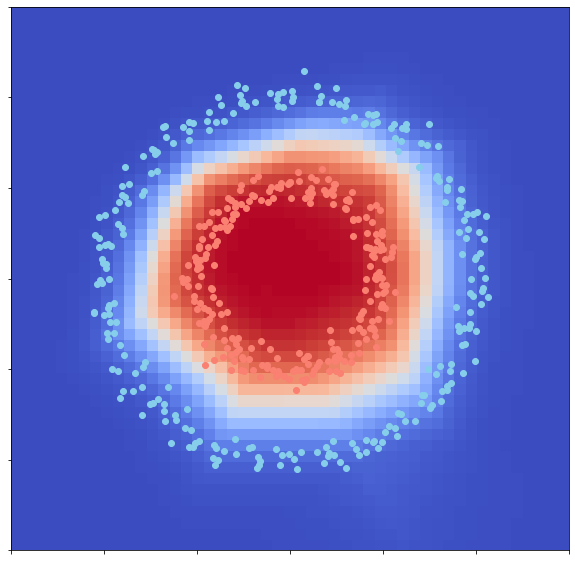

In [29]:
generateTrainingAnimation(X, Y, iPY)

## Keras

In [24]:
import tensorflow.keras as kr

learningRate = 0.025
nnTopology = [2, 16, 8, 1]

model = kr.Sequential() #Estructura que contiene nuestro modelo

#Capa 1
model.add(kr.layers.Dense(nnTopology[1], activation = 'relu'))

#Capa 2
model.add(kr.layers.Dense(nnTopology[2], activation = 'relu'))

#Capa 3
model.add(kr.layers.Dense(nnTopology[3], activation = 'sigmoid'))

#Compilamos el modelo
model.compile(loss = 'mse', optimizer = kr.optimizers.SGD(lr = learningRate), metrics = ['acc'])

#Entrenamos el modelo
model.fit(X, Y, epochs = 500, verbose = 1)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/500
500/500 [==============================] - 0s 511us/sample - loss: 0.2381 - acc: 0.5100
Epoch 2/500
500/500 [==============================] - 0s 31us/sample - loss: 0.2375 - acc: 0.5060
Epoch 3/500
500/500 [==============================] - 0s 58us/sample - loss: 0.2368 - acc: 0.5140
Epoch 4/500
500/500 [==============================] - 0s 32us/sample - loss: 0.2362 - acc: 0.5280
Epoch 5/500
500/500 [==============================] - 0s 28us/sample - loss: 0.2356 - acc: 0.5320
Epoch 6/500
500/500 [==============================] - 0s 45us/sample - loss: 0.2349 - acc: 0.5360
Epoch 7/500
500/500 [==============================] - 0s 28us/sample - loss: 0.2343 - acc: 0.5380
Epoch 8/500
500/500 [==============================] - 0s 20us/sample - loss: 0.2337 - acc: 0.5520
Epoch 9/500
500/500 [==============================] - 0s 23us/sample - loss: 0.2332 - ac

500/500 [==============================] - 0s 46us/sample - loss: 0.1564 - acc: 0.9860
Epoch 80/500
500/500 [==============================] - 0s 52us/sample - loss: 0.1548 - acc: 0.9880
Epoch 81/500
500/500 [==============================] - 0s 42us/sample - loss: 0.1531 - acc: 0.9900
Epoch 82/500
500/500 [==============================] - 0s 50us/sample - loss: 0.1515 - acc: 0.9900
Epoch 83/500
500/500 [==============================] - 0s 40us/sample - loss: 0.1498 - acc: 0.9900
Epoch 84/500
500/500 [==============================] - 0s 32us/sample - loss: 0.1482 - acc: 0.9900
Epoch 85/500
500/500 [==============================] - 0s 30us/sample - loss: 0.1464 - acc: 0.9900
Epoch 86/500
500/500 [==============================] - 0s 32us/sample - loss: 0.1447 - acc: 0.9960
Epoch 87/500
500/500 [==============================] - 0s 36us/sample - loss: 0.1431 - acc: 0.9940
Epoch 88/500
500/500 [==============================] - 0s 34us/sample - loss: 0.1413 - acc: 0.9960
Epoch 89/500


500/500 [==============================] - 0s 34us/sample - loss: 0.0446 - acc: 1.0000
Epoch 161/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0439 - acc: 1.0000
Epoch 162/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0432 - acc: 1.0000
Epoch 163/500
500/500 [==============================] - 0s 34us/sample - loss: 0.0426 - acc: 1.0000
Epoch 164/500
500/500 [==============================] - 0s 40us/sample - loss: 0.0420 - acc: 1.0000
Epoch 165/500
500/500 [==============================] - 0s 47us/sample - loss: 0.0414 - acc: 1.0000
Epoch 166/500
500/500 [==============================] - 0s 44us/sample - loss: 0.0407 - acc: 1.0000
Epoch 167/500
500/500 [==============================] - 0s 40us/sample - loss: 0.0402 - acc: 1.0000
Epoch 168/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0396 - acc: 1.0000
Epoch 169/500
500/500 [==============================] - 0s 36us/sample - loss: 0.0390 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 32us/sample - loss: 0.0171 - acc: 1.0000
Epoch 242/500
500/500 [==============================] - 0s 30us/sample - loss: 0.0170 - acc: 1.0000
Epoch 243/500
500/500 [==============================] - 0s 27us/sample - loss: 0.0168 - acc: 1.0000
Epoch 244/500
500/500 [==============================] - 0s 28us/sample - loss: 0.0167 - acc: 1.0000
Epoch 245/500
500/500 [==============================] - 0s 30us/sample - loss: 0.0166 - acc: 1.0000
Epoch 246/500
500/500 [==============================] - 0s 30us/sample - loss: 0.0164 - acc: 1.0000
Epoch 247/500
500/500 [==============================] - 0s 28us/sample - loss: 0.0163 - acc: 1.0000
Epoch 248/500
500/500 [==============================] - 0s 33us/sample - loss: 0.0161 - acc: 1.0000
Epoch 249/500
500/500 [==============================] - 0s 28us/sample - loss: 0.0160 - acc: 1.0000
Epoch 250/500
500/500 [==============================] - 0s 30us/sample - loss: 0.0159 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 50us/sample - loss: 0.0096 - acc: 1.0000
Epoch 323/500
500/500 [==============================] - 0s 52us/sample - loss: 0.0095 - acc: 1.0000
Epoch 324/500
500/500 [==============================] - 0s 58us/sample - loss: 0.0095 - acc: 1.0000
Epoch 325/500
500/500 [==============================] - 0s 92us/sample - loss: 0.0094 - acc: 1.0000
Epoch 326/500
500/500 [==============================] - 0s 68us/sample - loss: 0.0094 - acc: 1.0000
Epoch 327/500
500/500 [==============================] - 0s 56us/sample - loss: 0.0093 - acc: 1.0000
Epoch 328/500
500/500 [==============================] - 0s 64us/sample - loss: 0.0093 - acc: 1.0000
Epoch 329/500
500/500 [==============================] - 0s 42us/sample - loss: 0.0092 - acc: 1.0000
Epoch 330/500
500/500 [==============================] - 0s 46us/sample - loss: 0.0092 - acc: 1.0000
Epoch 331/500
500/500 [==============================] - 0s 62us/sample - loss: 0.0091 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 62us/sample - loss: 0.0065 - acc: 1.0000
Epoch 404/500
500/500 [==============================] - 0s 78us/sample - loss: 0.0064 - acc: 1.0000
Epoch 405/500
500/500 [==============================] - 0s 90us/sample - loss: 0.0064 - acc: 1.0000
Epoch 406/500
500/500 [==============================] - 0s 99us/sample - loss: 0.0064 - acc: 1.0000
Epoch 407/500
500/500 [==============================] - 0s 56us/sample - loss: 0.0064 - acc: 1.0000
Epoch 408/500
500/500 [==============================] - 0s 40us/sample - loss: 0.0063 - acc: 1.0000
Epoch 409/500
500/500 [==============================] - 0s 59us/sample - loss: 0.0063 - acc: 1.0000
Epoch 410/500
500/500 [==============================] - 0s 48us/sample - loss: 0.0063 - acc: 1.0000
Epoch 411/500
500/500 [==============================] - 0s 56us/sample - loss: 0.0063 - acc: 1.0000
Epoch 412/500
500/500 [==============================] - 0s 62us/sample - loss: 0.0062 - acc: 1.0000
Epoc

500/500 [==============================] - 0s 62us/sample - loss: 0.0048 - acc: 1.0000
Epoch 485/500
500/500 [==============================] - 0s 60us/sample - loss: 0.0048 - acc: 1.0000
Epoch 486/500
500/500 [==============================] - 0s 90us/sample - loss: 0.0048 - acc: 1.0000
Epoch 487/500
500/500 [==============================] - 0s 60us/sample - loss: 0.0048 - acc: 1.0000
Epoch 488/500
500/500 [==============================] - 0s 56us/sample - loss: 0.0048 - acc: 1.0000
Epoch 489/500
500/500 [==============================] - 0s 68us/sample - loss: 0.0047 - acc: 1.0000
Epoch 490/500
500/500 [==============================] - 0s 66us/sample - loss: 0.0047 - acc: 1.0000
Epoch 491/500
500/500 [==============================] - 0s 63us/sample - loss: 0.0047 - acc: 1.0000
Epoch 492/500
500/500 [==============================] - 0s 43us/sample - loss: 0.0047 - acc: 1.0000
Epoch 493/500
500/500 [==============================] - 0s 53us/sample - loss: 0.0047 - acc: 1.0000
Epoc

## Sklearn

In [25]:
import sklearn as sk
import sklearn.neural_network

learningRate = 0.025
topology = [2, 16, 8, 1]

model = sk.neural_network.MLPRegressor(solver = 'sgd',
                                       learning_rate_init = learningRate,
                                       hidden_layer_sizes = topology[1:],
                                       verbose = True,
                                       n_iter_no_change = 1000)

model.fit(X, Y.ravel()) #Entrenamos el modelo

Iteration 1, loss = 2.08761613
Iteration 2, loss = 1.24457641
Iteration 3, loss = 0.51831705
Iteration 4, loss = 0.17723562
Iteration 5, loss = 0.14209572
Iteration 6, loss = 0.21968759
Iteration 7, loss = 0.26827215
Iteration 8, loss = 0.24957012
Iteration 9, loss = 0.19682032
Iteration 10, loss = 0.15048033
Iteration 11, loss = 0.12778698
Iteration 12, loss = 0.12590286
Iteration 13, loss = 0.13167160
Iteration 14, loss = 0.13475478
Iteration 15, loss = 0.13327449
Iteration 16, loss = 0.12990121
Iteration 17, loss = 0.12697742
Iteration 18, loss = 0.12555244
Iteration 19, loss = 0.12520824
Iteration 20, loss = 0.12533592
Iteration 21, loss = 0.12531272
Iteration 22, loss = 0.12525741
Iteration 23, loss = 0.12512761
Iteration 24, loss = 0.12517956
Iteration 25, loss = 0.12508467
Iteration 26, loss = 0.12502364
Iteration 27, loss = 0.12501074
Iteration 28, loss = 0.12507155
Iteration 29, loss = 0.12502443
Iteration 30, loss = 0.12504328
Iteration 31, loss = 0.12504356
Iteration 32, los

D:\Programas\Anaconda3\envs\InformaticaTFG\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=[16, 8, 1], learning_rate_init=0.025,
             n_iter_no_change=1000, solver='sgd', verbose=True)

## Conclusiones

Podemos ver como, según vamos aumentando el nivel de abstracción, reducimos las líneas de código necesarias para crear y entrenar la red. Sin embargo, vamos perdiendo cada vez más capacidad de configurar nuestra red y reducimos el nivel de detalle al que podemos acceder.

Como "picar" todos los métodos necesarios para la red neuronal sería demasiado trabajo vamos a usar las librerías disponibles. Sklearn es quizás es de demasiado nivel de abstracción, lo cual está bien para aprender. Por ello, nos situaremos en un nivel intermedio entre Keras y Tensorflow, usando principalmente Keras pero "bajando" a Tensorflow cuando sea necesario.